In [9]:
#==============================================================================
# BLOCK 1: Loading Required Libraries and Saved Models/Data
#==============================================================================

# Suppress all warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Import custom plotting functions for model evaluation
from plots import bootstrap_and_plot, plot_top_feature_importances, plot_roc_curve, plot_precision_recall_curve, plot_roc_pr_curves

# Execute preprocessing script that contains functions for data cleaning and feature extraction
execfile('load_data_preprocess.py')

import pickle

# Load previously saved Bag-of-Words features
with open("features_bow_2231227_manualbow_l1_c10.pkl", "rb") as f:
    features_bow = pickle.load(f)

# Load non-zero features selected during previous feature selection
with open("non_zero_features_2231227_manualbow_l1_c10.pkl", "rb") as f:
    non_zero_features = pickle.load(f)

# Load the text vectorizer used to transform text data into numerical features
with open("vectorizer_2231227_manualbow_l1_c10.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Load the trained model (likely XGBoost based on later code)
with open("model4_2231227_manualbow_l1_c10.pkl", "rb") as f:
    model4 = pickle.load(f)

# Load training data with L1 regularization feature selection applied
with open("X_train_l1_selected_2231227_manualbow_l1_c10.pkl", "rb") as f:
    X_train_l1_selected = pickle.load(f)

# Load test data with L1 regularization feature selection applied
with open("X_test_l1_selected_2231227_manualbow_l1_c10.pkl", "rb") as f:
    X_test_l1_selected = pickle.load(f)

# Load training labels
with open("y_train_2231227_manualbow_l1_c10.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load test labels
with open("y_test_2231227_manualbow_l1_c10.pkl", "rb") as f:
    y_test = pickle.load(f)


['solution', 'suggest', 'initiation', 'nih', 'aki', 'stop', 'peg', 'ivf', 'ivbmbp', 'nrbc', 'came', 'young', 'might', 'swab', 'early', 'added', 'syndrome', 'closure', 'rather', 'previously', 'troponin', 'stop', 'sample', 'initial', 'location', 'tmax', 'syringe', 'provider', 'visit', 'impression', 'slightly', 'unable', 'related', 'drug', 'dyspnea', 'sinus', 'three', 'similar', 'first', 'already', 'pertinent', 'dysuria', 'ent', 'come', 'calcium', 'thank', 'sent', 'one', 'got', 'abdominal', 'reaction', 'ace', 'cardiovascular', 'cough', 'left', 'clinical', 'hypertension', 'diarrhea', 'loss', 'intravenous', 'mlhr', 'physical', 'meei', 'picc', 'june', 'diff', 'returned', 'resolved', 'temp', 'factor', 'creatinine', 'includes', 'rue', 'mgkg', 'intake', 'partner', 'crbc', 'hyperlipidemia', 'subsequent', 'making', 'ivpb', 'lue', 'study', 'disposition', 'cva', 'tid', 'soon', 'favor', 'hent', 'muscle', 'pursue', 'social', 'motoprolol', 'unit', 'voice', 'inject', 'facilityadministered', 'called', '

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bwestove/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bwestove/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#==============================================================================
# BLOCK 2: Defining Evaluation and Visualization Functions
#==============================================================================
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define font sizes for plots
size_a = 20  # Font size for axis labels
size_b = 22  # Font size for legend
size_c = 22  # Font size for titles

def bootstrap_and_plot(model, n_iterations, X_test_l1_selected, y_test, small=False):
    """
    Perform bootstrap resampling to generate confidence intervals for ROC and PR curves.
    
    Parameters:
    -----------
    model : trained machine learning model
        The model to evaluate
    n_iterations : int
        Number of bootstrap iterations to perform
    X_test_l1_selected : DataFrame
        Feature-selected test data
    y_test : Series
        True labels for test data
    small : bool, default=False
        If True, generates smaller plots for compact display
        
    Returns:
    --------
    dict
        Dictionary containing metrics and curve data
    """
    n_size = len(y_test)

    # Initialize lists to store results from each bootstrap iteration
    tprs = []          # True positive rates
    aucs_roc = []      # ROC AUC values
    precisions = []    # Precision values
    aucs_pr = []       # PR AUC values

    # Create common x-axis points for ROC and PR curves
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall_levels = np.linspace(0, 1, 100)

    # Perform bootstrap iterations with progress bar
    for _ in tqdm(range(n_iterations)):
        # Resample test data and labels with replacement
        X_resample, y_resample = resample(X_test_l1_selected, y_test, n_samples=n_size)
        y_prob_resample = model.predict_proba(X_resample)[:, 1]

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(y_resample, y_prob_resample)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs_roc.append(auc(fpr, tpr))

        # Calculate Precision-Recall curve metrics
        precision, recall, _ = precision_recall_curve(y_resample, y_prob_resample)
        precisions.append(np.interp(mean_recall_levels, recall[::-1], precision[::-1]))
        aucs_pr.append(auc(recall, precision))

    # Calculate mean metrics and confidence intervals
    mean_auroc = np.mean(aucs_roc)
    mean_auprc = np.mean(aucs_pr)
    auroc_ci = np.percentile(aucs_roc, [2.5, 97.5])
    auprc_ci = np.percentile(aucs_pr, [2.5, 97.5])

    # Set figure size based on 'small' parameter
    if small:
        figsize = (8, 3.5)  # Smaller size when 'small' is True
    else:
        figsize = (16, 7)   # Default size
    
    plt.figure(figsize=figsize)

    # Plot ROC Curve with confidence intervals
    plt.subplot(1, 2, 1)
    # Plot individual bootstrap iterations in light grey
    for i in range(n_iterations):
        plt.plot(mean_fpr, tprs[i], color='lightgrey', lw=0.5, alpha=0.1)
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    # Plot mean ROC curve
    plt.plot(mean_fpr, np.mean(tprs, axis=0), color='blue', lw=2, label=f'Mean AUROC: {mean_auroc:.3f}')
    # Plot confidence interval
    plt.fill_between(mean_fpr, np.percentile(tprs, 2.5, axis=0), np.percentile(tprs, 97.5, axis=0), 
                    color='grey', alpha=0.2, label=f'95% CI: [{auroc_ci[0]:.3f}, {auroc_ci[1]:.3f}]')
    # Add labels, title and formatting
    plt.xlabel('False Positive Rate', fontsize=size_a)
    plt.ylabel('True Positive Rate', fontsize=size_a)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=size_c)
    plt.legend(loc="lower right", fontsize=size_b)
    # Set grid and tick formatting
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.grid(which='major', linestyle='-', linewidth=.5, color='gray')
    plt.grid(which='minor', linestyle='-', linewidth=0.1, color='gray')
    plt.tick_params(which='minor', length=0)

    # Plot Precision-Recall Curve with confidence intervals
    plt.subplot(1, 2, 2)
    # Plot individual bootstrap iterations in light grey
    for i in range(n_iterations):
        plt.plot(mean_recall_levels, precisions[i], color='lightgrey', lw=0.5, alpha=0.1)
    # Plot mean PR curve
    plt.plot(mean_recall_levels, np.mean(precisions, axis=0), color='blue', lw=2, label=f'Mean AUPRC: {mean_auprc:.3f}')
    # Plot confidence interval
    plt.fill_between(mean_recall_levels, np.percentile(precisions, 2.5, axis=0), np.percentile(precisions, 97.5, axis=0), 
                    color='grey', alpha=0.2, label=f'95% CI: [{auprc_ci[0]:.3f}, {auprc_ci[1]:.3f}]')
    # Add labels, title and formatting
    plt.xlabel('Recall', fontsize=size_a)
    plt.ylabel('Precision', fontsize=size_a)
    plt.title('Precision-Recall Curve', fontsize=size_c)
    plt.legend(loc="lower left", fontsize=size_b)
    # Set grid and tick formatting
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.grid(which='major', linestyle='-', linewidth=.5, color='gray')
    plt.grid(which='minor', linestyle='-', linewidth=0.1, color='gray')
    plt.tick_params(which='minor', length=0)

    plt.tight_layout()
    plt.show()
    
    # Return dictionary with all important metrics and curves
    return {
        "mean_auroc": mean_auroc,
        "auroc_ci": auroc_ci,
        "mean_auprc": mean_auprc,
        "auprc_ci": auprc_ci,
        "mean_fpr": mean_fpr,
        "mean_tpr": np.mean(tprs, axis=0),
        "mean_recall_levels": mean_recall_levels,
        "mean_precision": np.mean(precisions, axis=0)
    }

def plot_top_feature_importances(model, n_features, small=False):
    """
    Plot the top N most important features based on the gain metric.
    
    Parameters:
    -----------
    model : trained model with feature_importance_ attribute (e.g., XGBoost)
        The model to extract feature importances from
    n_features : int
        Number of top features to display
    small : bool, default=False
        If True, generates smaller plots for compact display
    """
    # Get feature importance of type 'gain'
    feature_importance = model.get_booster().get_score(importance_type='gain')

    # Take the top n features by gain
    top_features = [k for k, v in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:n_features]]
    top_gains = [feature_importance[f] for f in top_features]

    # Sort the top n features and their gains in descending order
    top_features.reverse()
    top_gains.reverse()

    # Adjust plot size based on 'small' parameter
    if small:
        figsize = (5, 5)  # Smaller size for compact display
    else:
        figsize = (10, 20)  # Default larger size
    
    # Create horizontal bar chart of feature importances
    plt.figure(figsize=figsize)
    plt.barh(range(len(top_gains)), top_gains, color='skyblue')
    plt.yticks(ticks=range(len(top_features)), labels=top_features)
    plt.xlabel('Gain')
    plt.ylabel('Features')
    plt.title(f'Top {n_features} Feature Importance by Gain')
    plt.show()

def plot_roc_curve(y_test, y_prob):
    """
    Plot a simple ROC curve without bootstrapping.
    
    Parameters:
    -----------
    y_test : array-like
        True binary labels
    y_prob : array-like
        Predicted probabilities for the positive class
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_test, y_prob):
    """
    Plot a simple Precision-Recall curve without bootstrapping.
    
    Parameters:
    -----------
    y_test : array-like
        True binary labels
    y_prob : array-like
        Predicted probabilities for the positive class
    """
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

def plot_roc_pr_curves(y_test, y_prob, small=False):
    """
    Plot both ROC and Precision-Recall curves side by side.
    
    Parameters:
    -----------
    y_test : array-like
        True binary labels
    y_prob : array-like
        Predicted probabilities for the positive class
    small : bool, default=False
        If True, generates smaller plots for compact display
    """
    # Calculate ROC curve metrics
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve metrics
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    # Set figure size based on 'small' parameter
    if small:
        figsize = (7, 3)  # Smaller size for compact display
    else:
        figsize = (10, 4)  # Default size
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # ROC Curve plot
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc="lower right")

    # Precision-Recall Curve plot
    ax2.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.3f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="upper right")

    plt.show()

def bootstrap_and_plot_results(model, n_iterations, X_test_l1_selected, y_test, small=False):
    """
    Enhanced bootstrap function that calculates additional metrics (F1, recall, precision, specificity)
    and plots ROC and PR curves with confidence intervals.
    
    Parameters:
    -----------
    model : trained machine learning model
        The model to evaluate
    n_iterations : int
        Number of bootstrap iterations to perform
    X_test_l1_selected : DataFrame
        Feature-selected test data
    y_test : Series
        True labels for test data
    small : bool, default=False
        If True, generates smaller plots for compact display
        
    Returns:
    --------
    dict
        Dictionary containing all metrics with confidence intervals
    """
    import numpy as np
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score, recall_score, precision_score
    from sklearn.utils import resample
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    
    # Get test set size
    n_size = len(y_test)

    # Initialize lists to store results from each bootstrap iteration
    tprs = []          # True positive rates for ROC curve
    aucs_roc = []      # ROC AUC values
    precision_curves = []  # Precision values for PR curve
    aucs_pr = []       # PR AUC values
    
    # Initialize dictionaries to store classification metrics for both classes
    f1_scores = {"0": [], "1": []}
    recall_scores = {"0": [], "1": []}
    precision_scores = {"0": [], "1": []}
    specificities = {"0": [], "1": []}

    # Create common x-axis points for ROC and PR curves
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall_levels = np.linspace(0, 1, 100)

    # Use consistent random seeds for reproducibility
    seed = 42
    for _ in tqdm(range(n_iterations)):
        seed += 1
        # Resample test data with replacement
        X_resample, y_resample = resample(X_test_l1_selected, y_test, n_samples=n_size, random_state=seed)

        # Get predictions and probabilities
        y_pred_resample = model.predict(X_resample)
        y_prob_resample = model.predict_proba(X_resample)[:, 1]

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(y_resample, y_prob_resample)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs_roc.append(auc(fpr, tpr))

        # Calculate Precision-Recall curve metrics
        precision, recall, _ = precision_recall_curve(y_resample, y_prob_resample)
        precision_curves.append(np.interp(mean_recall_levels, recall[::-1], precision[::-1]))
        aucs_pr.append(auc(recall, precision))

        # Calculate confusion matrix elements
        tn, fp, fn, tp = confusion_matrix(y_resample, y_pred_resample).ravel()

        # Calculate F1 scores for both classes
        f1_scores["0"].append(f1_score(y_resample, y_pred_resample, pos_label=0))
        f1_scores["1"].append(f1_score(y_resample, y_pred_resample, pos_label=1))

        # Calculate recall (sensitivity) for both classes
        recall_scores["0"].append(recall_score(y_resample, y_pred_resample, pos_label=0))
        recall_scores["1"].append(recall_score(y_resample, y_pred_resample, pos_label=1))

        # Calculate precision for both classes
        precision_scores["0"].append(precision_score(y_resample, y_pred_resample, pos_label=0))
        precision_scores["1"].append(precision_score(y_resample, y_pred_resample, pos_label=1))

        # Calculate specificity for both classes
        specificity_0 = tn / (tn + fp) if tn + fp > 0 else 0
        specificity_1 = tp / (tp + fn) if tp + fn > 0 else 0
        specificities["0"].append(specificity_0)
        specificities["1"].append(specificity_1)

    # Calculate actual AUROC and AUPRC on the full test set (not bootstrap mean)
    # This was added on 20240529 to show actual performance metrics
    y_prob = model.predict_proba(X_test_l1_selected)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    mean_auroc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    mean_auprc = auc(recall, precision)
    
    # Calculate confidence intervals for ROC and PR metrics
    auroc_ci = np.percentile(aucs_roc, [2.5, 97.5])
    auprc_ci = np.percentile(aucs_pr, [2.5, 97.5])

    # Calculate mean values for all classification metrics
    mean_metrics = {
        "f1_scores": {label: np.mean(f1_scores[label]) for label in ["0", "1"]},
        "recall_scores": {label: np.mean(recall_scores[label]) for label in ["0", "1"]},
        "precision_scores": {label: np.mean(precision_scores[label]) for label in ["0", "1"]},
        "specificities": {label: np.mean(specificities[label]) for label in ["0", "1"]}
    }

    # Calculate confidence intervals for all classification metrics
    ci_metrics = {
        "f1_scores": {label: np.percentile(f1_scores[label], [2.5, 97.5]) for label in ["0", "1"]},
        "recall_scores": {label: np.percentile(recall_scores[label], [2.5, 97.5]) for label in ["0", "1"]},
        "precision_scores": {label: np.percentile(precision_scores[label], [2.5, 97.5]) for label in ["0", "1"]},
        "specificities": {label: np.percentile(specificities[label], [2.5, 97.5]) for label in ["0", "1"]}
    }

    # Set figure size based on 'small' parameter
    if small:
        figsize = (8, 3.5)  # Smaller size for compact display
    else:
        figsize = (16, 7)   # Default size
    
    plt.figure(figsize=figsize)

    # Plot ROC Curve with confidence intervals
    plt.subplot(1, 2, 1)
    # Plot individual bootstrap iterations
    for i in range(n_iterations):
        plt.plot(mean_fpr, tprs[i], color='lightgrey', lw=0.5, alpha=0.1)
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    # Plot mean ROC curve (shows actual AUROC instead of bootstrap mean since 20240529 update)
    plt.plot(mean_fpr, np.mean(tprs, axis=0), color='blue', lw=2, label=f'AUROC: {mean_auroc:.3f}')
    # Plot confidence interval
    plt.fill_between(mean_fpr, np.percentile(tprs, 2.5, axis=0), np.percentile(tprs, 97.5, axis=0), 
                    color='grey', alpha=0.2, label=f'95% CI: [{auroc_ci[0]:.3f}, {auroc_ci[1]:.3f}]')
    # Add labels, title and formatting
    plt.xlabel('False Positive Rate', fontsize=size_a)
    plt.ylabel('True Positive Rate', fontsize=size_a)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=size_c)
    plt.legend(loc="lower right", fontsize=size_b)
    # Add grid and tick formatting
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.grid(which='major', linestyle='-', linewidth=.5, color='gray')
    plt.grid(which='minor', linestyle='-', linewidth=0.1, color='gray')
    plt.tick_params(which='minor', length=0)

    # Plot Precision-Recall Curve with confidence intervals
    plt.subplot(1, 2, 2)
    # Plot individual bootstrap iterations
    for i in range(n_iterations):
        plt.plot(mean_recall_levels, precision_curves[i], color='lightgrey', lw=0.5, alpha=0.1)
    # Plot mean PR curve (shows actual AUPRC instead of bootstrap mean since 20240529 update)
    plt.plot(mean_recall_levels, np.mean(precision_curves, axis=0), color='blue', lw=2, label=f'AUPRC: {mean_auprc:.3f}')
    # Plot confidence interval
    plt.fill_between(mean_recall_levels, np.percentile(precision_curves, 2.5, axis=0), np.percentile(precision_curves, 97.5, axis=0), 
                    color='grey', alpha=0.2, label=f'95% CI: [{auprc_ci[0]:.3f}, {auprc_ci[1]:.3f}]')
    # Add labels, title and formatting
    plt.xlabel('Recall', fontsize=size_a)
    plt.ylabel('Precision', fontsize=size_a)
    plt.title('Precision-Recall Curve', fontsize=size_c)
    plt.legend(loc="lower left", fontsize=size_b)
    # Add grid and tick formatting
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.grid(which='major', linestyle='-', linewidth=.5, color='gray')
    plt.grid(which='minor', linestyle='-', linewidth=0.1, color='gray')
    plt.tick_params(which='minor', length=0)

    plt.tight_layout()
    plt.show()

    # Return comprehensive dictionary with all metrics and curve data
    return {
        "mean_auroc": mean_auroc,
        "auroc_ci": auroc_ci,
        "mean_auprc": mean_auprc,
        "auprc_ci": auprc_ci,
        "mean_fpr": mean_fpr,
        "mean_tpr": np.mean(tprs, axis=0),
        "mean_recall_levels": mean_recall_levels,
        "mean_precision": np.mean(precision_curves, axis=0),
        "mean_metrics": mean_metrics,
        "ci_metrics": ci_metrics
    }


In [13]:
#==============================================================================
# BLOCK 3: Loading and Preprocessing BIDMC Test Dataset
#==============================================================================
# Define column name containing the text reports
note_column = 'Report_Text'

# Load deidentified clinical notes from BIDMC
csv_path = 'bidmc_notes_deid.csv'
df_test = pd.read_csv(csv_path)

# Clean text by replacing carriage returns and newlines with spaces
df_test['Report_Text'] = df_test['Report_Text'].str.replace('\r', ' ')
df_test['Report_Text'] = df_test['Report_Text'].str.replace('\n', ' ')

# Apply regex matching to extract relevant text sections
# (match_regexes function is imported from load_data_preprocess.py)
df_test = match_regexes(df_test, note_column, buffer=100)

# Apply text preprocessing to the matched text
df_test['NoteTXT_matched'] = df_test['NoteTXT_matched'].apply(preprocess_text)

# Load annotations for BIDMC data
df_annot = pd.read_csv("annot_20240223.csv")

# Filter out records with annotation value of 2 (likely invalid or uncertain cases)
df_annot = df_annot[df_annot['val'] != 2]

# Select BIDMC test samples based on annotation indices
df_test = df_test.iloc[df_annot['current_empi']]

# Extract target labels and features for BIDMC test set
y_test_bidmc = df_annot['val']
X_test_bidmc = df_test['NoteTXT_matched']


100%|█████████████████████████████████████████| 600/600 [00:07<00:00, 82.78it/s]


In [14]:
#==============================================================================
# BLOCK 4: Subsetting MGB Test Data for Evaluation
#==============================================================================
# This list contains indices of samples from the MGB (Mass General Brigham) dataset
# to include in the evaluation. These indices represent a curated subset of the
# original test set, likely selected to ensure a balanced and representative sample.
indices_limited = [1,2,6,9,10,11,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,34,35,36,37,39,40,41,42,43,45,46,47,49,51,52,55,56,57,58,60,61,62,63,64,65,67,69,70,73,74,75,76,78,79,80,81,83,85,86,87,88,89,90,91,92,93,94,96,97,98,99,101,102,103,104,105,106,107,108,110,111,112,113,114,116,117,118,119,120,122,123,124,125,126,128,129,130,131,133,134,135,137,139,140,141,142,143,144,145,146,147,148,149,153,155,157,160,161,163,164,166,167,169,170,171,172,173,174,177,178,179,180,182,183,184,185,186,187,189,191,192,193,194,196,198,199,200,201,202,204,206,207,208,210,211,212,215,217,218,220,222,223,224,225,227,228,231,232,234,237,240,244,245,246,247,249,250,251,252,254,255,256,257,258,259,261,262,263,264,265,266,269,270,271,272,273,274,275,276,280,283,284,285,286,288,290,294,295,296,297,299,300,301,305,306,307,309,310,311,312,313,314,315,316,317,318,319,320,321,323,324,325,326,327,328,329,330,331,332,333,335,336,337,338,339,340,341,342,343,344,346,347,348,349,350,351,353,354,355,356,357,359,362,363,364,368,369,370,371,372,373,374,376,377,378,379,380,383,384,385,386,388,389,390,391,392,394,395,396,398,399,400,402,403,405,406,408,409,410,411,412,413,414,415,416,417,418,420,421,424,425,426,427,429,431,432,433,435,436,437,438,439,440,441,442,443,444,446,447,448,449,450,453,454,455,456,458,459,460,461,463,465,466,467,468,469,472,473,474,476,477,479,481,483,484,485,486,487,488,490,491,492,493,494,496,497,498,500,502,503,504,505,506,507,509,510,511,512,513,514,516,518,519,520,521,523,524,525,526,527,528,529,530,532,533,535,536,537,538,540,541,543,545,546,548,549,550,551,552,553,554,555,557,558,560,561,563,564,565,566,567,568,569,572,573,575,576,577,578,579,581,586,588,590,591,592,593,595,596,597,598,599]

# Extract the subset of feature-selected test data using the indices
X_test_l1_selected_limited = X_test_l1_selected.iloc[indices_limited]

# Extract the corresponding labels for this limited test set
y_test_limited = y_test.iloc[indices_limited]


In [15]:
#==============================================================================
# BLOCK 5: Label Corrections for Enhanced Model Evaluation (June 6, 2024)
#==============================================================================
# Create copies of the test labels to apply corrections without modifying originals
# These corrections likely reflect expert review of model predictions
y_test_limited_changed_20240606 = y_test_limited.copy()
y_test_bidmc_changed_20240606 = y_test_bidmc.copy()

# Define BIDMC samples that need to be changed to class 0
# These are cases where the original labels were incorrect based on expert review
bi_change_to_0 = [284, 34, 33, 6, 35]

# Define MGB samples that need label corrections
mgb_change_to_0 = [80, 382]  # Samples to change to class 0
mgb_change_to_1 = [384]      # Samples to change to class 1

# Apply corrections to BIDMC labels
for x in bi_change_to_0:
    # Find the index in the dataframe where current_empi matches the value
    # and set the corresponding label to 0
    y_test_bidmc_changed_20240606.iloc[df_annot[df_annot['current_empi']==x].index] = 0

# Apply corrections to MGB labels
for x in mgb_change_to_0:
    y_test_limited_changed_20240606.loc[x] = 0
for x in mgb_change_to_1:
    y_test_limited_changed_20240606.loc[x] = 1


100%|███████████████████████████████████████| 1000/1000 [00:49<00:00, 20.02it/s]


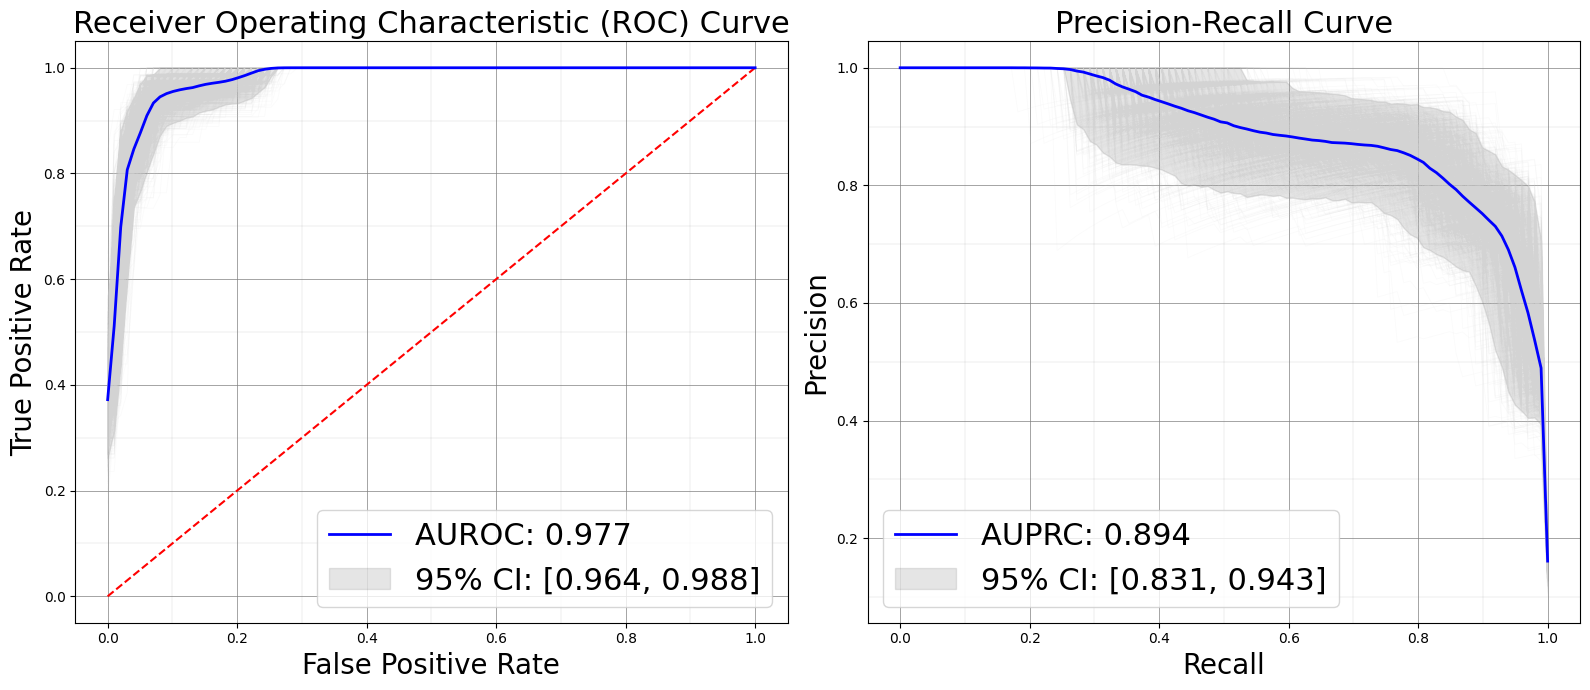

In [16]:
#==============================================================================
# BLOCK 6: Evaluate Model on MGB Dataset with Corrected Labels
#==============================================================================
# Run bootstrap evaluation on the MGB dataset with 1000 iterations
# This evaluation uses the corrected labels from June 6, 2024
# Parameters:
#   - model4: The trained machine learning model
#   - 1000: Number of bootstrap iterations for confidence interval calculation
#   - X_test_l1_selected_limited: Feature-selected test data from MGB
#   - y_test_limited_changed_20240606: Corrected test labels
#   - small=False: Generate full-sized plots

# The result is stored in df_testing_mgb_445_changed, which contains:
# - AUROC and AUPRC with confidence intervals
# - Mean values for various performance metrics (F1, recall, precision, specificity)
# - ROC and PR curve data points
df_testing_mgb_445_changed = bootstrap_and_plot_results(model4, 1000, X_test_l1_selected_limited, 
                                                       y_test_limited_changed_20240606, small=False)


In [17]:
#==============================================================================
# BLOCK 7: Prepare BIDMC Data for External Validation
#==============================================================================
# Transform the BIDMC text data using the same vectorizer used for MGB data
# This ensures feature consistency between training and external validation
X_test_bidmc = vectorizer.transform(X_test_bidmc)

# Convert sparse matrix to DataFrame with feature names as columns
X_test_bidmc = pd.DataFrame(X_test_bidmc.toarray(), columns=vectorizer.get_feature_names_out())

# Apply the same feature selection as used in the MGB model
# This ensures we use only the non-zero features identified during training
X_test_bidmc_2 = X_test_bidmc[non_zero_features]


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.78it/s]


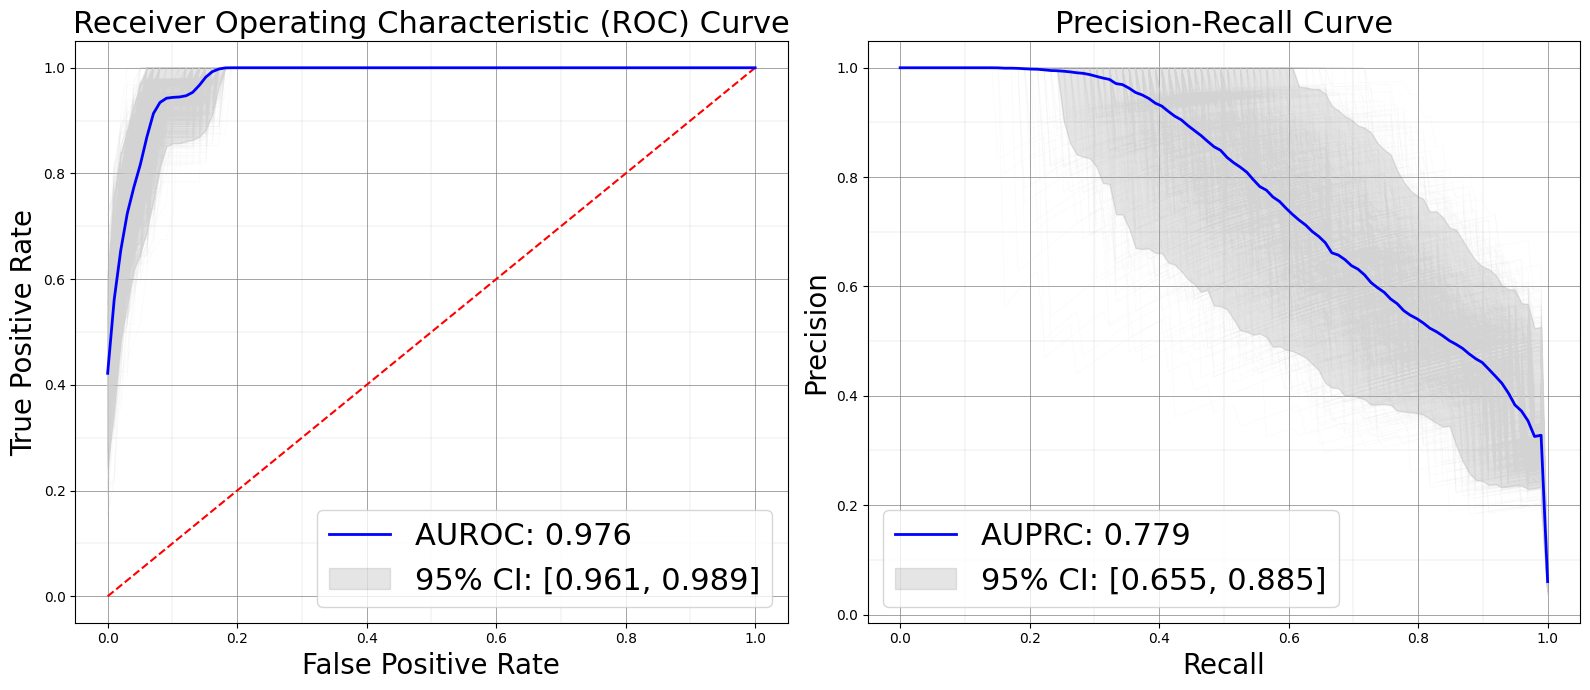

In [18]:
#==============================================================================
# BLOCK 8: Evaluate Model on BIDMC External Validation Dataset
#==============================================================================
# Run bootstrap evaluation on the BIDMC external validation dataset with 1000 iterations
# This tests the model's generalizability to data from a different institution
# Parameters:
#   - model4: The same trained model used for MGB evaluation
#   - 1000: Number of bootstrap iterations for confidence interval calculation
#   - X_test_bidmc_2: Feature-selected test data from BIDMC
#   - y_test_bidmc_changed_20240606: Corrected test labels for BIDMC
#   - small=False: Generate full-sized plots

# The result is stored in df_testing_bi_600_changed, which contains the same metrics as above
# Comparing df_testing_mgb_445_changed and df_testing_bi_600_changed allows assessment of
# how well the model generalizes across different institutions (MGB vs BIDMC)
df_testing_bi_600_changed = bootstrap_and_plot_results(model4, 1000, X_test_bidmc_2, 
                                                      y_test_bidmc_changed_20240606, small=False)

# At this point, the evaluation is complete, and the results can be used for:
# 1. Reporting model performance with confidence intervals
# 2. Comparing performance between MGB and BIDMC datasets
# 3. Assessing model generalizability across different institutions
# 4. Creating publication-quality figures showing ROC and PR curves